# YoloV8

本教程旨在为您提供一个完整、清晰的指南，带您一步步完成在自定义数据集上微调和优化 YOLOv8 模型。深入理解每一个环节的目的和具体实现。

## **引言：我们的目标**

本教程的目标是掌握一个可复现、标准化的目标检测模型训练流程。我们将从零开始，完成以下核心任务：

1. **环境搭建**：配置一个干净的、可用于模型训练的工作环境。
2. **数据处理**：从公开数据源（Hugging Face）获取数据，并将其转换为YOLOv8训练所需的特定格式。
3. **数据校验**：通过自动和人工的方式，确保转换后的数据准确无误。
4. **模型训练**：使用YOLOv8的强大功能，在我们的自定义数据上进行模型微调。
5. **结果分析**：学习如何解读训练过程中产生的图表和指标，以评估模型性能。
6. **推理部署**：使用训练好的模型对新图片进行预测，并为生产部署做好准备。

现在，让我们开始吧！

## **第一步：环境与项目设置**

一个良好规划的项目结构是成功的一半。我们将首先创建必要的目录，并安装所需的Python库。

### **1.1 安装依赖库**

YOLOv8的训练依赖于`ultralytics`库，数据处理则需要`datasets`等库。

In [ ]:
# 使用 -q (quiet) 标志来减少不必要的输出，保持界面整洁
!pip install -q ultralytics datasets tqdm pillow pyyaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.2 MB/s eta 0:00:00


### **1.2 设置工作目录**

我们将所有文件（数据、代码、结果）都存放在一个统一的根目录下，这有助于保持项目整洁，并方便路径管理。在Colab环境中，我们通常会将其设置在Google Drive中，以实现持久化存储。

In [ ]:
import os
import shutil # 用于文件操作，例如删除旧目录

# 挂载 Google Drive (仅在Colab环境中需要)
try:
    from google.colab import drive
    print("--> 正在挂载 Google Drive...")
    drive.mount('/content/drive')
    print("Google Drive 挂载成功！")
    # 定义并创建项目根目录
    BASE_DIR = "/content/drive/MyDrive/YOLOv8_Finetune_Project_Optimized"
except ImportError:
    # 在本地环境中，将项目根目录设置在当前工作目录下
    BASE_DIR = "./YOLOv8_Finetune_Project_Optimized"
    print(f"非Colab环境，项目根目录设置为: {os.path.abspath(BASE_DIR)}")

# 创建项目根目录（如果不存在）
if not os.path.exists(BASE_DIR):
    os.makedirs(BASE_DIR)
    print(f"项目根目录已创建: {BASE_DIR}")
else:
    print(f"项目根目录已存在: {BASE_DIR}")

# 切换当前工作目录至项目根目录，这是非常关键的一步！
os.chdir(BASE_DIR)
print(f"当前工作目录已切换至: {os.getcwd()}")


--> 正在挂载 Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive 挂载成功！
项目根目录已存在: /content/drive/MyDrive/YOLOv8_Finetune_Project_Optimized
当前工作目录已切换至: /content/drive/MyDrive/YOLOv8_Finetune_Project_Optimized


## 第二步：全局配置
为了方便管理和修改实验参数，我们将所有重要的配置项都定义在一个GlobalConfig类中。

### **2.1 定义配置类**

这种方式让代码更具可读性，当您想更换数据集或调整训练参数时，只需修改这个区域即可。

In [ ]:
from dataclasses import dataclass, field
from typing import List

@dataclass
class GlobalConfig:
    """
    管理项目所有配置的单一数据类，采用统一的类别控制逻辑。
    """
    # --- 核心类别配置 ---
    # 1. 填入类别名称，如 ['person', 'car']，将只训练这些类别。
    # 2. 保持列表为空，如 []，将自动训练数据集中所有可用类别。
    TARGET_CLASSES: List[str] = field(default_factory=lambda: [])

    # --- 数据集配置 ---
    DATASET_NAME: str = "detection-datasets/coco"
    DATASET_SPLIT: str = "train"
    VAL_SPLIT_RATIO: float = 0.1

    # --- 路径与训练配置 ---
    YOLO_DATA_DIR: str = "yolo_dataset_unified"
    PRETRAINED_MODEL: str = 'yolov8m.pt'
    EPOCHS: int = 30
    PATIENCE: int = 5
    BATCH_SIZE: int = 32
    IMG_SIZE: int = 416
    OPTIMIZER: str = 'AdamW'
    PROJECT_NAME: str = 'YOLOv8_Finetune_Results'

    @property
    def RUN_NAME(self) -> str:
        """根据目标类别列表动态生成运行名称"""
        if not self.TARGET_CLASSES: # 检查列表是否为空
            return f'{self.PRETRAINED_MODEL.split(".")[0]}_on_all_classes'
        else:
            target_str = "_".join(sorted(self.TARGET_CLASSES))
            return f'{self.PRETRAINED_MODEL.split(".")[0]}_on_{target_str}'

# 实例化配置
cfg = GlobalConfig()
# 您可以在这里轻松定义训练目标
# cfg.TARGET_CLASSES = ['person']
# cfg.TARGET_CLASSES = [] # 训练所有类别

if not cfg.TARGET_CLASSES:
    print("\n--> 全局配置加载完毕。模式: 完整训练 (目标列表为空)")
else:
    print(f"\n--> 全局配置加载完毕。模式: 部分训练 (目标: {cfg.TARGET_CLASSES})")


--> 全局配置加载完毕。模式: 完整训练 (目标列表为空)


## **第三步：数据准备**

这是整个流程中最核心、最耗时的一步。我们将原始数据集转换为YOLOv8可以“理解”的格式。

### **3.1 创建YOLO目录结构**

YOLOv8要求一个特定的目录结构来存放图片和标签。

- `yolo_dataset/`
  - `images/`
    - `train/` (存放训练图片)
    - `val/` (存放验证图片)
  - `labels/`
    - `train/` (存放训练标签)
    - `val/` (存放验证标签)
  - `dataset.yaml` (数据集配置文件)

In [ ]:
# 定义各级目录路径
YOLO_IMAGES_DIR = os.path.join(cfg.YOLO_DATA_DIR, "images")
YOLO_LABELS_DIR = os.path.join(cfg.YOLO_DATA_DIR, "labels")
YOLO_IMAGES_TRAIN_DIR = os.path.join(YOLO_IMAGES_DIR, "train")
YOLO_LABELS_TRAIN_DIR = os.path.join(YOLO_LABELS_DIR, "train")
YOLO_IMAGES_VAL_DIR = os.path.join(YOLO_IMAGES_DIR, "val")
YOLO_LABELS_VAL_DIR = os.path.join(YOLO_LABELS_DIR, "val")

# 清理旧数据（如果存在），确保从干净的状态开始
if os.path.exists(cfg.YOLO_DATA_DIR):
    print(f"发现旧的数据目录 '{cfg.YOLO_DATA_DIR}'，正在清理...")
    # 添加 ignore_errors=True 来处理云端文件系统的同步问题
    shutil.rmtree(cfg.YOLO_DATA_DIR, ignore_errors=True)

# 创建所有必需的目录
os.makedirs(YOLO_IMAGES_TRAIN_DIR, exist_ok=True)
os.makedirs(YOLO_LABELS_TRAIN_DIR, exist_ok=True)
os.makedirs(YOLO_IMAGES_VAL_DIR, exist_ok=True)
os.makedirs(YOLO_LABELS_VAL_DIR, exist_ok=True)
print("YOLOv8目录结构创建成功！")


发现旧的数据目录 'yolo_dataset_unified'，正在清理...
YOLOv8目录结构创建成功！


### **3.2 加载与筛选数据集**

我们从Hugging Face加载数据集，并只保留包含我们目标类别（`person`）的样本。

In [ ]:
from datasets import load_dataset
import yaml

print(f"正在从 Hugging Face 加载数据集: {cfg.DATASET_NAME}...")
dataset = load_dataset(cfg.DATASET_NAME, split=cfg.DATASET_SPLIT)
print("数据集加载成功！")

# 从数据集元信息中获取所有类别的名称
all_class_names = dataset.features['objects']['category'].feature.names

# 根据配置确定最终要训练的类别列表
if not cfg.TARGET_CLASSES:
    # 如果目标列表为空，则使用所有类别
    final_class_names = all_class_names
    print(f"将使用数据集中全部 {len(final_class_names)} 个类别进行训练。")
    # 无需筛选数据集
    filtered_dataset = dataset
else:
    # 如果目标列表非空，则使用指定的子集
    final_class_names = cfg.TARGET_CLASSES
    print(f"将使用指定的 {len(final_class_names)} 个类别进行训练: {final_class_names}")

    # 筛选出包含这些目标类别的数据样本
    try:
        original_target_ids = {all_class_names.index(name) for name in final_class_names}
    except ValueError as e:
        print(f"错误：目标类别列表中的某个类别不在数据集中！ {e}")
        exit()

    def contains_target_classes(sample):
        return any(cat_id in original_target_ids for cat_id in sample['objects']['category'])

    print("正在筛选包含目标类别的数据样本...")
    filtered_dataset = dataset.filter(contains_target_classes, num_proc=os.cpu_count())

# 为最终的类别列表创建新的ID映射 (e.g., {'person': 0, 'car': 1})
final_class_map = {name: i for i, name in enumerate(final_class_names)}

print(f"处理后的数据集大小: {len(filtered_dataset)} 条样本。")


正在从 Hugging Face 加载数据集: detection-datasets/coco...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

(…)-00000-of-00040-67e35002d152155c.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

(…)-00001-of-00040-2c2b33b9504aa843.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

(…)-00002-of-00040-58e30306870b1de7.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

(…)-00003-of-00040-a77e00648e423963.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)-00004-of-00040-1df1755d6f7c9b17.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)-00005-of-00040-29ccfc8f52cfc9cb.parquet:   0%|          | 0.00/473M [00:00<?, ?B/s]

(…)-00006-of-00040-76f2d663d51dca0a.parquet:   0%|          | 0.00/483M [00:00<?, ?B/s]

(…)-00007-of-00040-797508421c59b99d.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

(…)-00008-of-00040-7ad10a6d6b442ef9.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

(…)-00009-of-00040-edc6018bb7abeee3.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

(…)-00010-of-00040-068d922af9742c1a.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)-00011-of-00040-2cf010e9592da434.parquet:   0%|          | 0.00/483M [00:00<?, ?B/s]

(…)-00012-of-00040-e26d7a054b1f8c7f.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

(…)-00013-of-00040-00a967ab3e2568fd.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

(…)-00014-of-00040-4f6a348405f3725f.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

(…)-00015-of-00040-ae8972f628750cea.parquet:   0%|          | 0.00/479M [00:00<?, ?B/s]

(…)-00016-of-00040-377112973594380c.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

(…)-00017-of-00040-e2f542f29ca61356.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

(…)-00018-of-00040-3650ae2c12a832eb.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

(…)-00019-of-00040-f262669c6302eb2d.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

(…)-00020-of-00040-d2763ce5e7ab097f.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

(…)-00021-of-00040-fb98d35ab4e6ca66.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

(…)-00022-of-00040-c4f90a7435af5217.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

(…)-00023-of-00040-31db5fa16e24d32d.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

(…)-00024-of-00040-786ee9123ad04e52.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

(…)-00025-of-00040-369c096f8c7d7ab6.parquet:   0%|          | 0.00/479M [00:00<?, ?B/s]

(…)-00026-of-00040-709cf1a409a2698c.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

(…)-00027-of-00040-c99041dbf751516d.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

(…)-00028-of-00040-5e11f3d596cb0db3.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)-00029-of-00040-988997614786b5b4.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

(…)-00030-of-00040-497df2d4082da46b.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

(…)-00031-of-00040-541a6ccf9f21093e.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

(…)-00032-of-00040-659aee4f72e8f525.parquet:   0%|          | 0.00/479M [00:00<?, ?B/s]

(…)-00033-of-00040-0074f368f6733826.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

(…)-00034-of-00040-edcd109018ecaf95.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

(…)-00035-of-00040-c8fd4fb1bb93114d.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

(…)-00036-of-00040-5d6d294fbed2af1b.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

(…)-00037-of-00040-cb1276b8824445cd.parquet:   0%|          | 0.00/479M [00:00<?, ?B/s]

(…)-00038-of-00040-15a5fd14791741e4.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

(…)-00039-of-00040-f1a97fa690638b05.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

(…)-00000-of-00002-c4f2e391ee4aba11.parquet:   0%|          | 0.00/404M [00:00<?, ?B/s]

(…)-00001-of-00002-7af5414a3b178949.parquet:   0%|          | 0.00/404M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/117266 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/4952 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/20 [00:00<?, ?it/s]

数据集加载成功！
将使用数据集中全部 80 个类别进行训练。
处理后的数据集大小: 117266 条样本。


### **3.3 格式转换**

这是最关键的转换逻辑。我们需要将每张图片和它的标注信息转换为YOLO格式的`.txt`文件。每个`.txt`文件对应一张图片，文件中的每一行代表一个物体，格式为： `<class_id> <x_center> <y_center> <width> <height>` 所有坐标都必须是相对于图片宽高归一化的（值在0到1之间）。

In [ ]:
# 定义灵活的格式转换函数
def convert_sample_to_yolo_flexible(sample, index, image_dest_dir, label_dest_dir, all_cls_names, final_cls_map):
    """
    一个灵活的转换函数，可以处理所有类别或部分类别。
    新增了边界框裁剪逻辑，以处理越界坐标。
    """
    image = sample['image']
    if image.mode != 'RGB': image = image.convert('RGB')

    image_id = sample.get('image_id', index)
    image_filename = f"img_{image_id}.jpg"
    image_save_path = os.path.join(image_dest_dir, image_filename)
    image.save(image_save_path)

    label_filename = os.path.splitext(image_filename)[0] + ".txt"
    label_path = os.path.join(label_dest_dir, label_filename)

    img_w, img_h = image.size
    if img_w == 0 or img_h == 0: return {}

    with open(label_path, 'w', encoding='utf-8') as f:
        if 'objects' not in sample or not sample['objects']['bbox']: return {}

        for i in range(len(sample['objects']['bbox'])):
            original_class_id = sample['objects']['category'][i]
            original_class_name = all_cls_names[original_class_id]

            if original_class_name in final_cls_map:
                new_id = final_cls_map[original_class_name]

                x, y, w, h = sample['objects']['bbox'][i]

                # --- 边界框清洗与裁剪 ---
                # 1. 计算绝对坐标 (x1, y1, x2, y2)
                x1, y1 = x, y
                x2, y2 = x + w, y + h

                # 2. 将坐标裁剪到图像边界内
                x1_clipped = max(0.0, x1)
                y1_clipped = max(0.0, y1)
                x2_clipped = min(float(img_w), x2)
                y2_clipped = min(float(img_h), y2)

                # 3. 如果裁剪后框的宽度或高度为0，则跳过此标注
                if x2_clipped <= x1_clipped or y2_clipped <= y1_clipped:
                    continue

                # 4. 从裁剪后的坐标重新计算中心点和宽高
                clipped_w = x2_clipped - x1_clipped
                clipped_h = y2_clipped - y1_clipped
                x_center = (x1_clipped + clipped_w / 2)
                y_center = (y1_clipped + clipped_h / 2)

                # 5. 使用裁剪后的值进行归一化
                norm_x_center = x_center / img_w
                norm_y_center = y_center / img_h
                norm_w = clipped_w / img_w
                norm_h = clipped_h / img_h
                # --- 裁剪逻辑结束 ---

                f.write(f"{new_id} {norm_x_center:.6f} {norm_y_center:.6f} {norm_w:.6f} {norm_h:.6f}\n")
    return {}

# 划分数据集并应用统一的转换函数
print("正在划分数据集并执行格式转换...")
shuffled_dataset = filtered_dataset.shuffle(seed=42)
split_dataset = shuffled_dataset.train_test_split(test_size=cfg.VAL_SPLIT_RATIO)
train_dataset = split_dataset['train']
val_dataset = split_dataset['test']

# 准备传递给map函数的参数
common_kwargs = {"all_cls_names": all_class_names, "final_cls_map": final_class_map}
train_kwargs = {"image_dest_dir": YOLO_IMAGES_TRAIN_DIR, "label_dest_dir": YOLO_LABELS_TRAIN_DIR, **common_kwargs}
val_kwargs = {"image_dest_dir": YOLO_IMAGES_VAL_DIR, "label_dest_dir": YOLO_LABELS_VAL_DIR, **common_kwargs}

num_workers = 8
print(f"正在转换训练集 (使用 {num_workers} 个并行进程)...")
train_dataset.map(convert_sample_to_yolo_flexible, with_indices=True, fn_kwargs=train_kwargs, num_proc=num_workers)
print(f"正在转换验证集 (使用 {num_workers} 个并行进程)...")
val_dataset.map(convert_sample_to_yolo_flexible, with_indices=True, fn_kwargs=val_kwargs, num_proc=num_workers)
print("数据转换完成！")

正在划分数据集并执行格式转换...
正在转换训练集 (使用 8 个并行进程)...


Map (num_proc=8):   0%|          | 0/105539 [00:00<?, ? examples/s]

正在转换验证集 (使用 8 个并行进程)...


Map (num_proc=8):   0%|          | 0/11727 [00:00<?, ? examples/s]

数据转换完成！


### **3.4 生成 dataset.yaml**

这个文件是YOLOv8的“导航图”，它告诉训练器去哪里找数据，以及数据集中包含哪些类别。

In [ ]:
import yaml

# 定义YAML文件所需的数据结构
yaml_data = {
    'path': os.path.abspath(cfg.YOLO_DATA_DIR), # 数据集的根目录
    'train': os.path.join('images', 'train'),    # 训练图片目录（相对于path）
    'val': os.path.join('images', 'val'),      # 验证图片目录（相对于path）
    'nc': len(final_class_names),           # 类别数量
    'names': final_class_names            # 类别名称列表
}

# 将数据写入YAML文件
YAML_FILE_PATH = os.path.join(cfg.YOLO_DATA_DIR, "dataset.yaml")
with open(YAML_FILE_PATH, 'w', encoding='utf-8') as f:
    yaml.dump(yaml_data, f, default_flow_style=False, sort_keys=False, allow_unicode=True)

print(f"配置文件已保存至: {YAML_FILE_PATH}")
print("\n--- YAML 文件内容预览 ---")
print(yaml.dump(yaml_data, allow_unicode=True))

配置文件已保存至: yolo_dataset_unified/dataset.yaml

--- YAML 文件内容预览 ---
names:
- person
- bicycle
- car
- motorcycle
- airplane
- bus
- train
- truck
- boat
- traffic light
- fire hydrant
- stop sign
- parking meter
- bench
- bird
- cat
- dog
- horse
- sheep
- cow
- elephant
- bear
- zebra
- giraffe
- backpack
- umbrella
- handbag
- tie
- suitcase
- frisbee
- skis
- snowboard
- sports ball
- kite
- baseball bat
- baseball glove
- skateboard
- surfboard
- tennis racket
- bottle
- wine glass
- cup
- fork
- knife
- spoon
- bowl
- banana
- apple
- sandwich
- orange
- broccoli
- carrot
- hot dog
- pizza
- donut
- cake
- chair
- couch
- potted plant
- bed
- dining table
- toilet
- tv
- laptop
- mouse
- remote
- keyboard
- cell phone
- microwave
- oven
- toaster
- sink
- refrigerator
- book
- clock
- vase
- scissors
- teddy bear
- hair drier
- toothbrush
nc: 80
path: /content/drive/MyDrive/YOLOv8_Finetune_Project_Optimized/yolo_dataset_unified
train: images/train
val: images/val



## **第四步：数据验证**

“Garbage in, garbage out.” 在投入计算资源进行训练之前，验证数据的正确性至关重要。

### **4.1 文件数量一致性检查**

一个简单的检查，确保每张图片都有一个对应的标签文件。

In [ ]:
train_image_count = len(os.listdir(YOLO_IMAGES_TRAIN_DIR))
train_label_count = len(os.listdir(YOLO_LABELS_TRAIN_DIR))
if train_image_count == train_label_count:
    print(f"✅ 训练集文件数量匹配: {train_image_count} 个。")
else:
    print("❌ 警告：训练集图片和标签数量不匹配！")

✅ 训练集文件数量匹配: 105539 个。


### **4.2 可视化抽查**

我们将随机抽取几张图片，并将标签文件中的边界框画在图上，直观地判断转换是否正确。


正在随机抽查3张训练图片进行可视化验证...

🔍 正在检查图片: img_237233.jpg
在交互式环境中，直接显示图片：


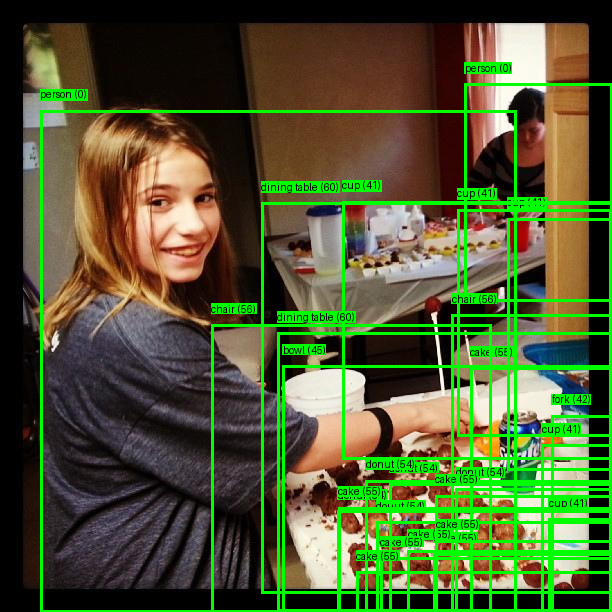


🔍 正在检查图片: img_507952.jpg
在交互式环境中，直接显示图片：


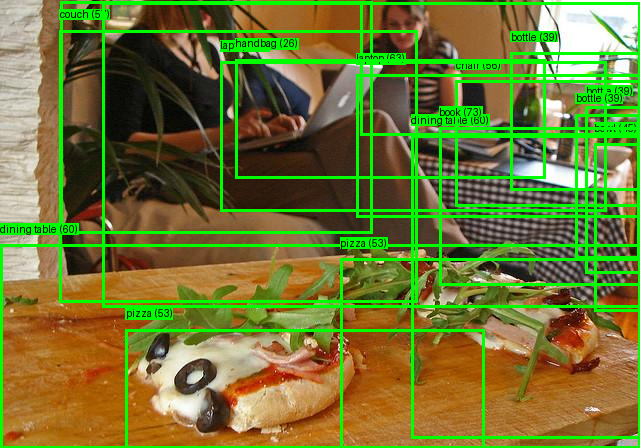


🔍 正在检查图片: img_224727.jpg
在交互式环境中，直接显示图片：


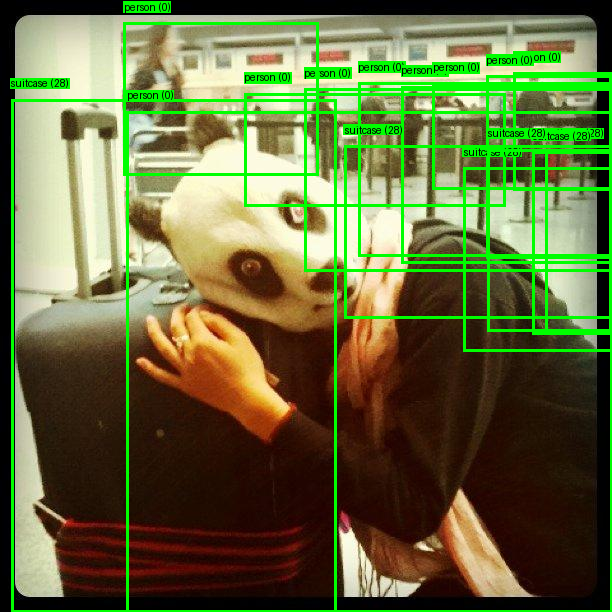

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import random
import os

# 尝试导入IPython.display，如果失败则说明不在Jupyter/Colab环境中
try:
    from IPython.display import display
    IS_INTERACTIVE_ENV = True
except ImportError:
    IS_INTERACTIVE_ENV = False

def visualize_yolo_label(image_path, label_path, class_names_map):
    """可视化单个YOLO标签，确认转换是否正确。"""
    try:
        image = Image.open(image_path).convert("RGB")
        img_w, img_h = image.size
        draw = ImageDraw.Draw(image)
        try:
            # 尝试加载一个通用的字体，如果失败则使用默认字体
            font = ImageFont.truetype("arial.ttf", 20)
        except IOError:
            font = ImageFont.load_default()

        if not os.path.exists(label_path):
            print(f"  - 警告：找不到对应的标签文件: {os.path.basename(label_path)}")
            return image

        with open(label_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    print(f"  - 警告：标签行格式错误: {line}")
                    continue

                class_id, x_center, y_center, norm_w, norm_h = map(float, parts)
                class_id = int(class_id)

                # 将归一化坐标反转为像素坐标
                box_w = norm_w * img_w
                box_h = norm_h * img_h
                x1 = (x_center * img_w) - (box_w / 2)
                y1 = (y_center * img_h) - (box_h / 2)
                x2 = x1 + box_w
                y2 = y1 + box_h

                # 获取类别名称
                class_name = class_names_map.get(class_id, "未知类别")

                # 绘制边界框
                draw.rectangle([x1, y1, x2, y2], outline="lime", width=3)

                # 准备并绘制标签文本
                label_text = f"{class_name} ({class_id})"
                text_bbox = draw.textbbox((x1, y1 - 22), label_text, font=font)
                draw.rectangle(text_bbox, fill="lime")
                draw.text((x1, y1 - 22), label_text, fill="black", font=font)
        return image
    except Exception as e:
        print(f"可视化图片 {os.path.basename(image_path)} 时发生错误: {e}")
        return None

print("\n正在随机抽查3张训练图片进行可视化验证...")
# 从之前生成的yaml_data中获取类别映射
class_names_map = {i: name for i, name in enumerate(yaml_data['names'])}
# 定义训练图片目录
YOLO_IMAGES_TRAIN_DIR = os.path.join(cfg.YOLO_DATA_DIR, "images", "train")
YOLO_LABELS_TRAIN_DIR = os.path.join(cfg.YOLO_DATA_DIR, "labels", "train")
image_files = os.listdir(YOLO_IMAGES_TRAIN_DIR)

if image_files:
    for i in range(min(3, len(image_files))):
        random_image_name = random.choice(image_files)
        image_path = os.path.join(YOLO_IMAGES_TRAIN_DIR, random_image_name)
        label_name = os.path.splitext(random_image_name)[0] + ".txt"
        label_path = os.path.join(YOLO_LABELS_TRAIN_DIR, label_name)

        print(f"\n🔍 正在检查图片: {random_image_name}")
        visualized_image = visualize_yolo_label(image_path, label_path, class_names_map)
        if visualized_image:
            if IS_INTERACTIVE_ENV:
                print("在交互式环境中，直接显示图片：")
                display(visualized_image)
            else:
                save_path = f"verification_sample_{i}.jpg"
                visualized_image.save(save_path)
                print(f"非交互式环境，验证图片已保存至: {save_path}")
else:
    print("❌ 训练图片文件夹为空，无法进行可视化验证！")


## **第五步：模型训练**

数据准备就绪，现在可以开始训练了！

In [ ]:
from ultralytics import YOLO

import torch

# --- 自动设备选择 ---
# 检查是否有可用的GPU，如果有，则使用第一块GPU(0)，否则使用CPU
if torch.cuda.is_available():
    device = 0
    print("✅ 检测到可用的GPU，将使用 device=0 进行训练。")
else:
    device = 'cpu'
    print("⚠️ 未检测到可用的GPU，将使用 device='cpu' 进行训练。这会非常慢。")
# --- 自动设备选择结束 ---

print("\n--> 开始模型训练...")

# 加载一个预训练模型，这将大大加快收敛速度
model = YOLO(cfg.PRETRAINED_MODEL)

# 调用 .train() 方法并传入所有配置参数
results = model.train(
    data=YAML_FILE_PATH,
    epochs=cfg.EPOCHS,
    patience=cfg.PATIENCE,
    batch=cfg.BATCH_SIZE,
    imgsz=cfg.IMG_SIZE,
    optimizer=cfg.OPTIMIZER,
    project=cfg.PROJECT_NAME,
    name=cfg.RUN_NAME,
    exist_ok=True, # 如果运行目录已存在，则覆盖
    device=device,
    half=True,       # 启用FP16混合精度训练
    workers=8       # 增加数据加载的工作线程数
)

print("训练完成！")
best_model_path = os.path.join(cfg.PROJECT_NAME, cfg.RUN_NAME, 'weights', 'best.pt')
print(f"最佳模型保存在: {best_model_path}")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ 检测到可用的GPU，将使用 device=0 进行训练。

--> 开始模型训练...
Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset_unified/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=True, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=4


                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics.nn.modules.conv.Conv             [384

 15                  -1  2    517632  ultralytics.nn.modules.block.C2f             [576, 192, 2]                 
 16                  -1  1    332160  ultralytics.nn.modules.conv.Conv             [192, 192, 3, 2]              
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  2   1846272  ultralytics.nn.modules.block.C2f             [576, 384, 2]                 
 19                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  2   4207104  ultralytics.nn.modules.block.C2f             [960, 576, 2]                 
 22        [15, 18, 21]  1   3822016  ultralytics.nn.modules.head.Detect           [80, [192, 384, 576]]         
Model summary: 169 layers, 25,902,640 parameters, 25,902,624 gradients, 79.3 GFLOPs

Tra

train: Scanning /content/drive/MyDrive/YOLOv8_Finetune_Project_Optimized/yolo_dataset_unified/labels/train... 105539 images, 0 backgrounds, 0 corrupt: 100%|██████████| 105539/105539 [13:25<00:00, 130.98it/s]

train: /content/drive/MyDrive/YOLOv8_Finetune_Project_Optimized/yolo_dataset_unified/images/train/img_201706.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/YOLOv8_Finetune_Project_Optimized/yolo_dataset_unified/images/train/img_214087.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/YOLOv8_Finetune_Project_Optimized/yolo_dataset_unified/images/train/img_522365.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/YOLOv8_Finetune_Project_Optimized/yolo_dataset_unified/images/train/img_99844.jpg: 2 duplicate labels removed


train: New cache created: /content/drive/MyDrive/YOLOv8_Finetune_Project_Optimized/yolo_dataset_unified/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 20.3±7.4 MB/s, size: 44.6 KB)


val: Scanning /content/drive/MyDrive/YOLOv8_Finetune_Project_Optimized/yolo_dataset_unified/labels/val... 11727 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11727/11727 [01:18<00:00, 148.59it/s]


val: New cache created: /content/drive/MyDrive/YOLOv8_Finetune_Project_Optimized/yolo_dataset_unified/labels/val.cache
Plotting labels to YOLOv8_Finetune_Results/yolov8m_on_all_classes/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to YOLOv8_Finetune_Results/yolov8m_on_all_classes
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      5.53G      1.416      2.949      1.765         21        416: 100%|██████████| 3299/3299 [16:01<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [01:49<00:00,  1.69it/s]


                   all      11727      85826       0.26      0.122     0.0653     0.0314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      8.19G      1.288      2.698      1.677         41        416: 100%|██████████| 3299/3299 [15:41<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [01:09<00:00,  2.65it/s]


                   all      11727      85826      0.288      0.252      0.176     0.0995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      8.27G      1.214      2.505      1.616         22        416: 100%|██████████| 3299/3299 [15:23<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [01:08<00:00,  2.70it/s]


                   all      11727      85826      0.339       0.29      0.222      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      8.32G      1.164      2.376      1.575         75        416: 100%|██████████| 3299/3299 [15:20<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [01:05<00:00,  2.79it/s]


                   all      11727      85826       0.35      0.331      0.262      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       8.4G       1.12       2.26       1.54         59        416: 100%|██████████| 3299/3299 [15:22<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [01:06<00:00,  2.78it/s]


                   all      11727      85826      0.388       0.36      0.296      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      8.46G       1.09      2.181      1.517         48        416: 100%|██████████| 3299/3299 [15:22<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [01:04<00:00,  2.84it/s]


                   all      11727      85826      0.391      0.384      0.316      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      8.54G      1.064      2.118      1.497         38        416: 100%|██████████| 3299/3299 [15:22<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [01:05<00:00,  2.83it/s]


                   all      11727      85826      0.402      0.401      0.331      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      8.59G      1.045       2.07      1.482         50        416: 100%|██████████| 3299/3299 [15:22<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [01:04<00:00,  2.85it/s]


                   all      11727      85826      0.411      0.407      0.341      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      8.67G       1.03      2.029      1.469         25        416: 100%|██████████| 3299/3299 [15:21<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [01:03<00:00,  2.88it/s]


                   all      11727      85826      0.415      0.418       0.35      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      8.72G      1.015      1.996      1.456         67        416: 100%|██████████| 3299/3299 [1:08:56<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [01:04<00:00,  2.87it/s]


                   all      11727      85826      0.409      0.424      0.356       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30       8.8G      1.004      1.968      1.448         81        416: 100%|██████████| 3299/3299 [2:27:42<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [16:28<00:00,  5.37s/it]


                   all      11727      85826      0.424      0.428      0.361      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      8.82G     0.9927      1.937      1.439        547        416:  53%|█████▎    | 1750/3299 [46:59<44:08,  1.71s/it]

提示：想获得更好的性能吗？可以尝试YOLOv8的超参数自动搜索功能，只需在train函数中加入tune=True参数即可。

### YOLOv8 训练指标解读



在训练过程中，您会看到两组核心指标，一组关于**训练本身**，另一组关于**模型性能验证**。

------



#### **表1：训练过程指标 (Training Progress)**



这组指标告诉您模型在学习过程中的“努力程度”和“学习方向”。

| 参数           | 含义             | 如何解读                                                     |
| -------------- | ---------------- | ------------------------------------------------------------ |
| **`Epoch`**    | **训练轮次**     | 当前训练的进度，例如 `2/50` 表示总共50轮，正在进行第2轮。    |
| **`GPU_mem`**  | **显存占用**     | 显示您的GPU被使用了多少显存。如果这个值接近您显卡的总显存，可能会导致训练变慢或出错。 |
| **`box_loss`** | **边界框损失**   | 模型预测的框与真实框的位置、大小差异。**值越低越好**，代表模型定位越来越准。 |
| **`cls_loss`** | **分类损失**     | 模型判断物体类别的准确性。**值越低越好**，代表模型分类越来越准。 |
| **`dfl_loss`** | **分布焦距损失** | 一种更先进的边界框损失，同样**值越低越好**。                 |


**核心要点**：您希望看到这三个 `loss` 值随着 `Epoch` 的增加而**持续稳定地下降**，这表明模型正在有效地从数据中学习。

------



#### **表2：验证结果指标 (Validation Results)**



这组指标是**衡量模型好坏的最终标准**，它告诉您模型在新数据上的泛化能力。

| 参数                | 含义                 | 如何解读                                                     |
| ------------------- | -------------------- | ------------------------------------------------------------ |
| **`P` (Precision)** | **精确率**           | “宁缺毋滥”。在所有模型预测出的框中，有多少是正确的。**值越高越好**，代表模型不乱报。 |
| **`R` (Recall)**    | **召回率**           | “宁滥勿缺”。在所有真实的物体中，模型成功找到了多少。**值越高越好**，代表模型找得全。 |
| **`mAP50`**         | **核心指标**         | 在IoU阈值为0.5时，模型的平均准确度。这是最常用的评估标准，**值越高越好**。 |
| **`mAP50-95`**      | **最严格的核心指标** | 在多个IoU阈值（从0.5到0.95）下的平均mAP。**值越高越好**，代表模型不仅能找到物体，而且框的位置画得非常精准。 |


**核心要点**：您需要结合这两组指标来看：**训练损失(`loss`)持续下降的同时，验证集的`mAP`指标也要持续上升**，这才是最理想的训练状态。如果训练损失下降但mAP不再上升，说明可能出现了过拟合。

## **第六步：分析训练结果**

训练结束后，YOLOv8会在结果目录中生成`results.csv`文件和各种图表。我们可以用代码重新绘制这些图表，以便更深入地分析。

/tmp/ipython-input-437283200.py:51: UserWarning: Glyph 36793 (\N{CJK UNIFIED IDEOGRAPH-8FB9}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-437283200.py:51: UserWarning: Glyph 30028 (\N{CJK UNIFIED IDEOGRAPH-754C}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-437283200.py:51: UserWarning: Glyph 26694 (\N{CJK UNIFIED IDEOGRAPH-6846}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-437283200.py:51: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-437283200.py:51: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-437283200.py:51: UserWarning: Glyph 25351 (\N{CJK UNIFIED IDEOGRAPH-6307}) missing from font(s) DejaVu Sans.
  plt.tight_

训练结果图表已保存至: YOLOv8_Finetune_Results/yolov8m_on_all_classes/training_dashboard.png


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36793 (\N{CJK UNIFIED IDEOGRAPH-8FB9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30028 (\N{CJK UNIFIED IDEOGRAPH-754C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26694 (\N{CJK UNIFIED IDEOGRAPH-6846}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  fig.canvas

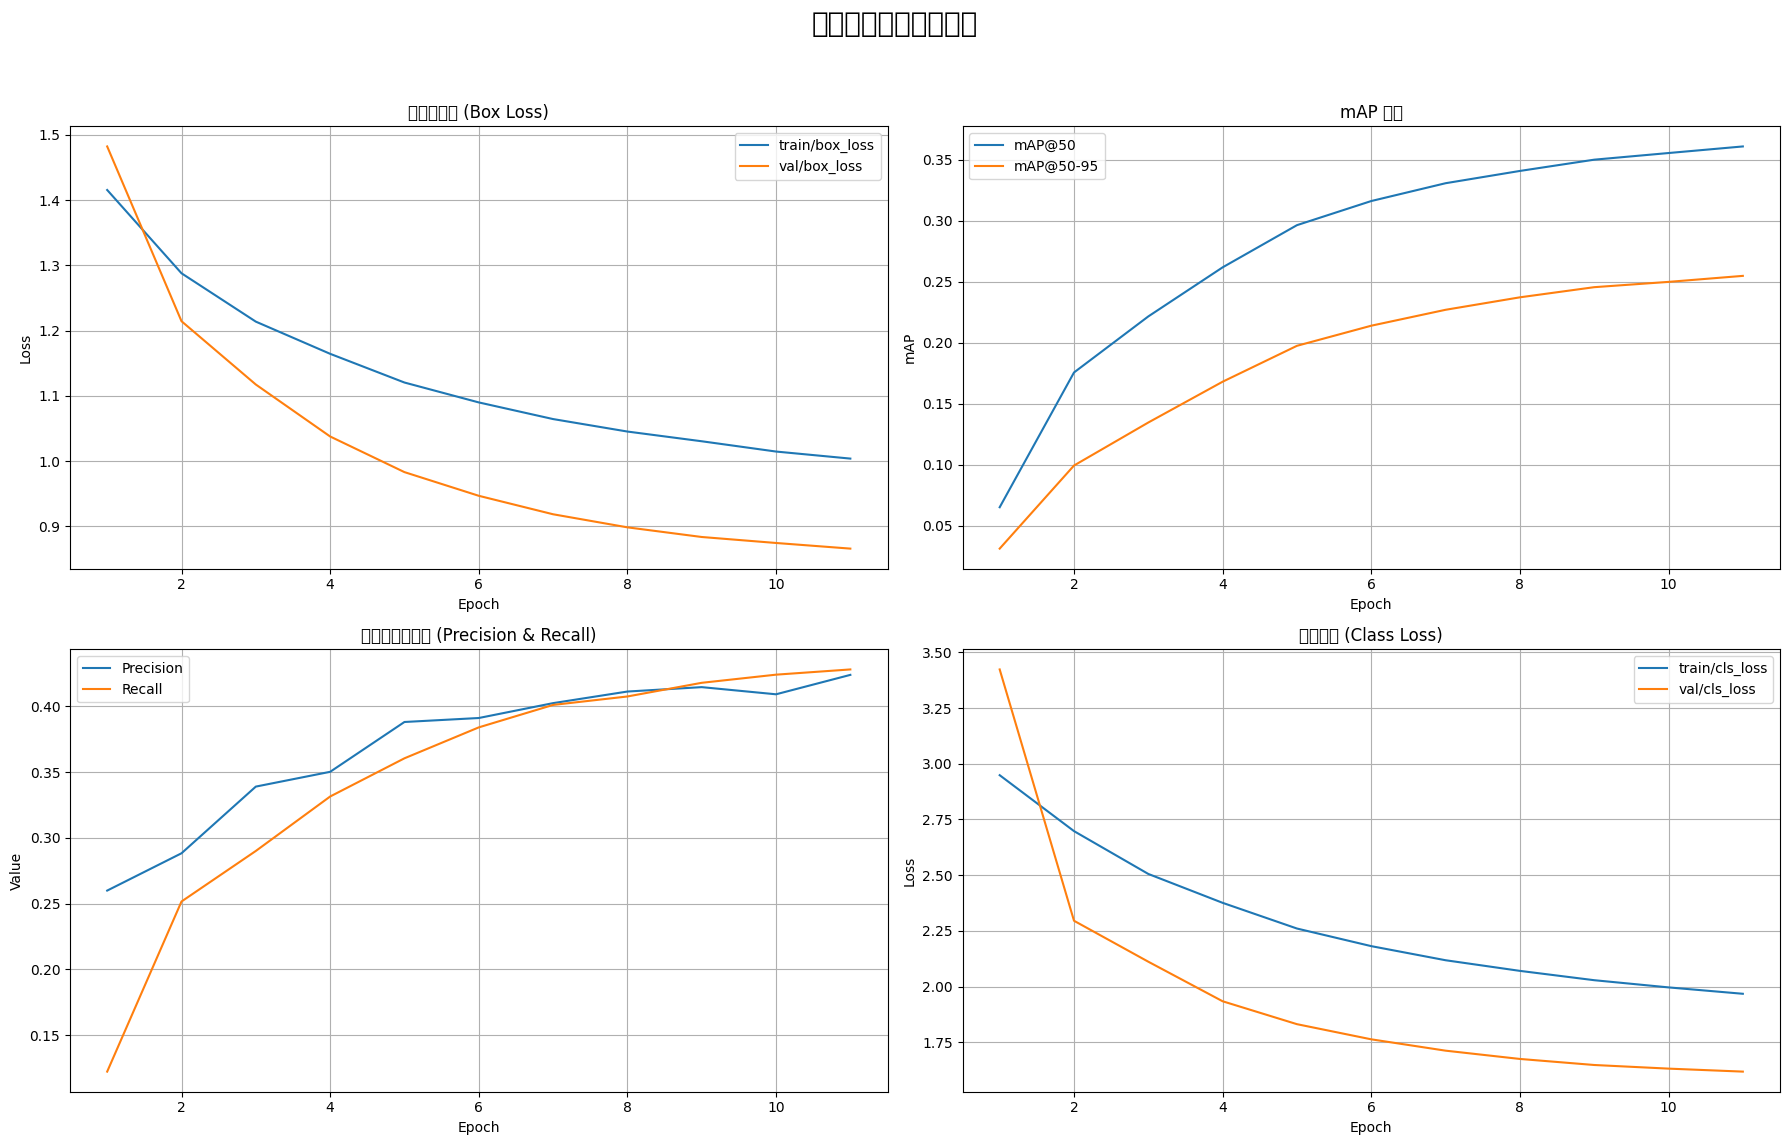

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

run_dir = os.path.join(cfg.PROJECT_NAME, cfg.RUN_NAME)
results_csv_path = os.path.join(run_dir, 'results.csv')

if os.path.exists(results_csv_path):
    results_df = pd.read_csv(results_csv_path)
    # 清理列名，去除可能存在的前后空格
    results_df.columns = results_df.columns.str.strip()

    fig, axs = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('训练过程可视化仪表盘', fontsize=20)

    # 图1: 边界框损失 (Box Loss)
    axs[0, 0].plot(results_df['epoch'], results_df['train/box_loss'], label='train/box_loss')
    axs[0, 0].plot(results_df['epoch'], results_df['val/box_loss'], label='val/box_loss')
    axs[0, 0].set_title('边界框损失 (Box Loss)')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # 图2: mAP 指标
    axs[0, 1].plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP@50')
    axs[0, 1].plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='mAP@50-95')
    axs[0, 1].set_title('mAP 指标')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('mAP')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # 图3: 精确率与召回率
    axs[1, 0].plot(results_df['epoch'], results_df['metrics/precision(B)'], label='Precision')
    axs[1, 0].plot(results_df['epoch'], results_df['metrics/recall(B)'], label='Recall')
    axs[1, 0].set_title('精确率与召回率 (Precision & Recall)')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Value')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # 图4: 分类损失 (Class Loss)
    axs[1, 1].plot(results_df['epoch'], results_df['train/cls_loss'], label='train/cls_loss')
    axs[1, 1].plot(results_df['epoch'], results_df['val/cls_loss'], label='val/cls_loss')
    axs[1, 1].set_title('分类损失 (Class Loss)')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Loss')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plot_save_path = os.path.join(run_dir, "training_dashboard.png")
    plt.savefig(plot_save_path)
    print(f"训练结果图表已保存至: {plot_save_path}")
    # plt.show() # 在Jupyter/Colab中可以取消注释以直接显示
else:
    print(f"未找到训练日志文件: {results_csv_path}。无法绘制图表。")

通过观察这些图表，您可以判断模型是否存在过拟合（验证损失上升）或欠拟合（所有损失下降缓慢）等问题。

## 第七步：推理与验证

让我们用训练好的最佳模型来检测一张新图片，看看效果如何。

正在使用图片进行推理: yolo_dataset_unified/images/val/img_274079.jpg

image 1/1 /content/drive/MyDrive/YOLOv8_Finetune_Project_Optimized/yolo_dataset_unified/images/val/img_274079.jpg: 320x416 (no detections), 69.1ms
Speed: 1.6ms preprocess, 69.1ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 416)

--- 推理结果 (包含置信度) ---


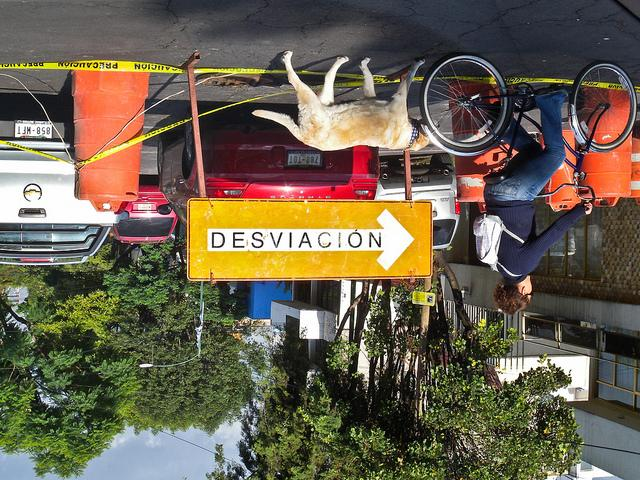

In [ ]:
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import random
import os

# 加载我们微调后的最佳模型
best_model_path = os.path.join(cfg.PROJECT_NAME, cfg.RUN_NAME, 'weights', 'best.pt')
if not os.path.exists(best_model_path):
    print(f"❌ 错误：找不到训练好的模型文件于 {best_model_path}")
else:
    model = YOLO(best_model_path)

    # 从验证集中随机选择一张图片进行测试
    # Define YOLO_IMAGES_VAL_DIR here
    YOLO_IMAGES_VAL_DIR = os.path.join(cfg.YOLO_DATA_DIR, "images", "val")
    val_image_files = os.listdir(YOLO_IMAGES_VAL_DIR)
    if not val_image_files:
        print("❌ 警告：验证集文件夹为空，无法进行推理。")
    else:
        test_image_name = random.choice(val_image_files)
        test_image_path = os.path.join(YOLO_IMAGES_VAL_DIR, test_image_name)
        print(f"正在使用图片进行推理: {test_image_path}")

        # 执行推理
        results = model(test_image_path, conf=0.25) # conf是置信度阈值

        # 手动绘制结果以显示置信度
        result = results[0]
        img = Image.open(result.path).convert("RGB")
        draw = ImageDraw.Draw(img)
        try:
            font = ImageFont.truetype("arial.ttf", 20)
        except IOError:
            font = ImageFont.load_default()

        # 遍历每个检测到的边界框
        for box in result.boxes:
            xyxy = box.xyxy[0].cpu().numpy() # 获取坐标 (x1, y1, x2, y2)
            conf = box.conf[0].cpu().numpy() # 获取置信度
            cls_id = int(box.cls[0].cpu().numpy()) # 获取类别ID

            class_name = model.names[cls_id] # 从模型中获取类别名称
            label = f"{class_name}: {conf:.2f}" # 创建标签文本

            # 绘制边界框
            draw.rectangle(xyxy.tolist(), outline="red", width=3)

            # 绘制标签背景和文本
            text_bbox = draw.textbbox((xyxy[0], xyxy[1]), label, font=font)
            draw.rectangle(text_bbox, fill="red")
            draw.text((xyxy[0], xyxy[1]), label, fill="white", font=font)

        print("\n--- 推理结果 (包含置信度) ---")
        run_dir = os.path.join(cfg.PROJECT_NAME, cfg.RUN_NAME)
        # inference_save_path = os.path.join(run_dir, "inference_result.jpg")
        # img.save(inference_save_path)
        # print(f"推理结果图片已保存至: {inference_save_path}")

## 第八步：模型导出（可选）

为了在生产环境中使用，通常需要将模型导出为更通用的格式，如ONNX，或针对特定硬件（如NVIDIA GPU）优化为TensorRT引擎，以获得极致的推理速度。

In [ ]:
from ultralytics import YOLO

best_model_path = os.path.join(cfg.PROJECT_NAME, cfg.RUN_NAME, 'weights', 'best.pt')
if os.path.exists(best_model_path):
    model = YOLO(best_model_path)
    try:
        # 导出为 ONNX 格式，使用半精度(FP16)以加速
        print("正在导出为 ONNX 格式...")
        onnx_path = model.export(format='onnx', half=True)
        print(f"✅ 模型成功导出为 ONNX 格式: {onnx_path}")

        # 提示: 如果您在有NVIDIA GPU和TensorRT的环境中，可以取消下面的注释来获得极致的推理速度
        # print("\n正在导出为 TensorRT 引擎 (可能需要一些时间)...")
        # engine_path = model.export(format='engine', half=True)
        # print(f"✅ 模型成功导出为 TensorRT 引擎: {engine_path}")

    except Exception as e:
        print(f"❌ 模型导出失败: {e}")
else:
    print(f"❌ 找不到最佳模型于 {best_model_path}，无法进行导出。")


正在导出为 ONNX 格式...
Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
WARNING ⚠️ half=True only compatible with GPU export, i.e. use device=0
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 92 layers, 25,886,080 parameters, 0 gradients, 78.9 GFLOPs

PyTorch: starting from 'YOLOv8_Finetune_Results/yolov8m_on_all_classes/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 84, 3549) (148.7 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.59', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 4.4s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.64...
ONNX: export success ✅ 7.4s, saved as 'YOLOv8_Finetune_Results/yolov8m_on_all